In [1]:
from numpy import mean, std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

In [2]:
# load dataset
def load_dataset():
  (trainX, trainY), (testX, testY) = mnist.load_data()
  #reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0],28,28,1))
  testX = testX.reshape((testX.shape[0],28,28,1))
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

In [3]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [4]:
# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
	# compile model
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [5]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  plt.show()

In [7]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

11501568/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


> 98.600
> 98.517
> 98.525
> 98.825
> 98.708


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


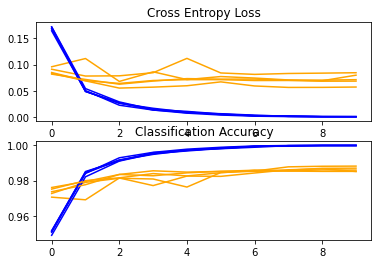

Accuracy: mean=98.635 std=0.117, n=5


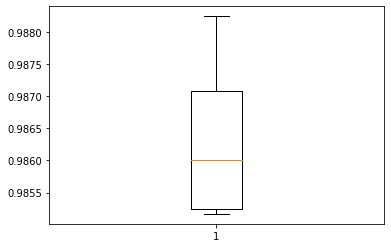

In [8]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)